#### Importowanie modułów

In [ ]:
# !pip install --upgrade torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms, datasets
from torchvision.models import EfficientNet_B0_Weights
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Zbiory danych, modele, metody TL, hiperparametry

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


# This is needed for efficient net to work for some reason
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

DATASETS = [
    'CIFAR10',
    #'dogs-vs-cats',
    #'hats-vs-nohats'
]
MODELS = [
    #models.alexnet(pretrained=True),
    #models.vgg16(pretrained=True),
    models.resnet50(pretrained=True),
    models.efficientnet_b0(pretrained=True)
]
TL_METHODS = [
    #'no_freezing',
    #'classic_tl',
    'fine_tuning'
]

# Hyperparmeters
EPOCHS = 1
BATCH_SIZE = 64

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


#### Utworzenie Data setów i data loaderów

In [ ]:
def create_datasets_and_dataloaders(dataset_name: str, model):

    if isinstance(model, models.AlexNet) or isinstance(model, models.VGG) or isinstance(model, models.ResNet) or isinstance(model,models.EfficientNet):
        base_transforms = [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    else:
        base_transforms = [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]

    train_transform = transforms.Compose(base_transforms)
    test_transform = transforms.Compose(base_transforms)

    preprocessing = [
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(0.5),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
    ]

    train_transform.transforms.extend(preprocessing)

    train_set, test_set, train_loader, test_loader = 0, 0, 0, 0

    if dataset_name == 'CIFAR10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

        classes = train_set.classes
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
        print("Loaders created")

    elif dataset_name in ['dogs-vs-cats', 'hats-vs-nohats']:
        train_dataset_full = datasets.ImageFolder(root=f'D:/Users/rafal/PycharmProjects/TransferLearningResearch/data/{dataset_name}', transform=train_transform)
        test_dataset_temp = datasets.ImageFolder(root=f'D:/Users/rafal/PycharmProjects/TransferLearningResearch/data/{dataset_name}', transform=test_transform)

        classes = train_dataset_full.classes
        total_size = len(train_dataset_full)
        train_size = int(0.8 * total_size)
        validation_size = total_size - train_size
        train_set, validation_set = torch.utils.data.random_split(train_dataset_full, [train_size, validation_size])

        test_set = torch.utils.data.Subset(test_dataset_temp, [i for i in range(total_size) if i not in train_set.indices])

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
        print("Loaders created")


    return classes, train_loader, test_loader

#### Przetwarzanie modeli do transfer learningu

In [ ]:
def apply_transfer_learning(model, tl_method):
    if tl_method == 'classic_tl' or tl_method == 'fine_tuning':
        for param in model.parameters():
            param.requires_grad = False

        if isinstance(model, models.AlexNet) or isinstance(model, models.VGG) or isinstance(model, models.EfficientNet):
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif isinstance(model, models.ResNet):
            for param in model.fc.parameters():
                param.requires_grad = True

    elif tl_method == 'no_freezing':
        for param in model.parameters():
            param.requires_grad = True


def customize_model(model, num_classes, tl_method):
    if isinstance(model, models.AlexNet):
        dropout = 0.5
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    elif isinstance(model, models.VGG):
        dropout = 0.5
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    elif isinstance(model, models.ResNet):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif isinstance(model, models.EfficientNet):
        model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    print("Classifier for model has been changed.")
    apply_transfer_learning(model, tl_method)
    print("Transfer learning method:", tl_method, "applied.")

    return model

#### Funkcja mrożąca do naszej metody

In [ ]:

def freeze_percentage(model, percentage):
    """Freeze a percentage of the model's parameters based on gradient norms."""
    grad_params = [(param.grad.norm(), param) for param in model.parameters() if param.requires_grad and param.grad is not None]
    grad_params.sort(key=lambda x: x[0])
    num_params_to_freeze = int(percentage * len(grad_params))

    for _, param in grad_params[:num_params_to_freeze]:
        param.requires_grad = False

#### Ustawienia fine-tuningu

In [ ]:
def adjust_fine_tuning(model, optimizer):
    """Adjust the model and optimizer for fine-tuning."""
    for param in model.parameters():
        param.requires_grad = True
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.0001

#### Pętla treningowo walidacyjna

Using: cuda
Using the CIFAR10 dataset.
Using the fine_tuning method
Files already downloaded and verified
Files already downloaded and verified
Loaders created
Using the ResNet model
Classifier for model has been changed.
Transfer learning method: fine_tuning applied.
Training starts


Epoch 1: 100%|██████████| 782/782 [04:13<00:00,  3.08it/s, loss=0.735]


Train Loss: 0.8504537415245305, Validation Loss: 0.6889812936828394, Accuracy: 76.22%
Fine tuning applied. Learning rate:  0.0001


Epoch 1: 100%|██████████| 782/782 [09:33<00:00,  1.36it/s, loss=0.227]


Train Loss: 0.2761314780787205, Validation Loss: 0.18484849273968654, Accuracy: 93.64%
{'train_loss': [0.8504537415245305], 'val_loss': [0.6889812936828394], 'train_accuracy': [71.636], 'val_accuracy': [76.22]}
{'train_loss': [0.2761314780787205], 'val_loss': [0.18484849273968654], 'train_accuracy': [90.576], 'val_accuracy': [93.64]}
{'train_loss': [0.8504537415245305, 0.2761314780787205], 'val_loss': [0.6889812936828394, 0.18484849273968654], 'train_accuracy': [71.636, 90.576], 'val_accuracy': [76.22, 93.64]}


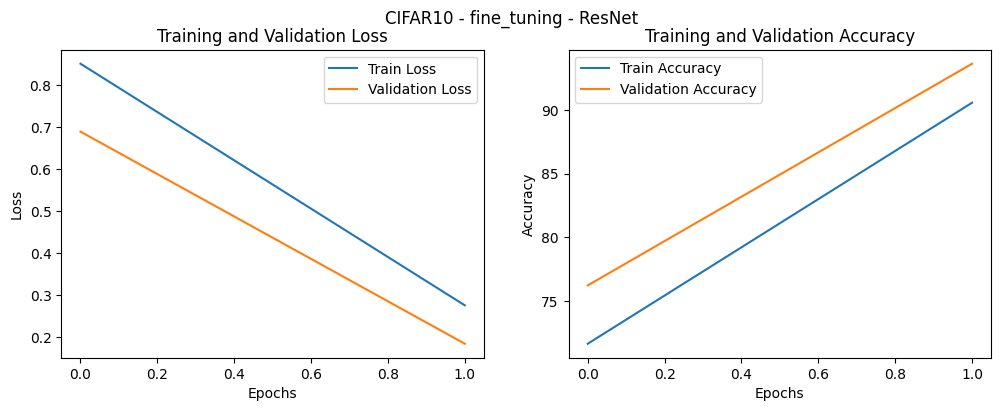

Files already downloaded and verified
Files already downloaded and verified
Loaders created
Using the EfficientNet model
Classifier for model has been changed.
Transfer learning method: fine_tuning applied.
Training starts


Epoch 1: 100%|██████████| 782/782 [02:55<00:00,  4.46it/s, loss=1.02]


Train Loss: 0.9465479477287253, Validation Loss: 0.6745264296698722, Accuracy: 77.47%
Fine tuning applied. Learning rate:  0.0001


Epoch 1: 100%|██████████| 782/782 [05:40<00:00,  2.30it/s, loss=0.628]


Train Loss: 0.31821033158494383, Validation Loss: 0.16509646189155852, Accuracy: 94.23%
{'train_loss': [0.9465479477287253], 'val_loss': [0.6745264296698722], 'train_accuracy': [70.09], 'val_accuracy': [77.47]}
{'train_loss': [0.31821033158494383], 'val_loss': [0.16509646189155852], 'train_accuracy': [89.066], 'val_accuracy': [94.23]}
{'train_loss': [0.9465479477287253, 0.31821033158494383], 'val_loss': [0.6745264296698722, 0.16509646189155852], 'train_accuracy': [70.09, 89.066], 'val_accuracy': [77.47, 94.23]}


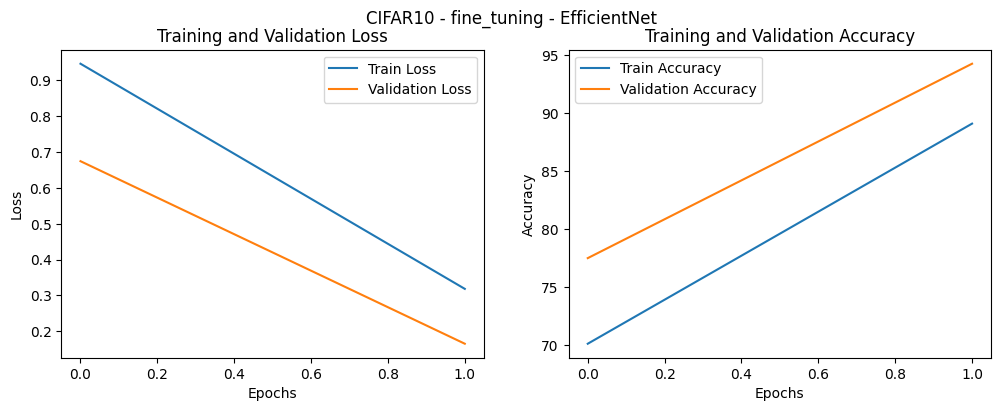

In [ ]:
# Import PrettyTable to store training history
from prettytable import PrettyTable
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using: {device}")

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, tl_method):
    """Train and evaluate the model."""

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch + 1}") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                tepoch.set_postfix(loss=loss.item())

        train_accuracy = 100 * correct_train / total_train
        val_loss, val_accuracy = evaluate_model(model, test_loader, criterion, running_loss)

        history['train_loss'].append(running_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

    if tl_method == 'fine_tuning':
        adjust_fine_tuning(model, optimizer)
        print("Fine tuning applied. Learning rate: ", optimizer.param_groups[0]['lr'])
        tl_method = 'no_freezing'
        fine_tuning_history = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, tl_method)
        print(history)
        print(fine_tuning_history)
        # history = {key: history[key].extend(fine_tuning_history[key]) for key in history}
        history = {key: history[key] + fine_tuning_history[key] for key in history}

        # history.update(fine_tuning_history)
        print(history)


    return history


def evaluate_model(model, test_loader, criterion, running_loss):
    """Evaluate the model and adjust learning rate if fine-tuning."""
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Train Loss: {running_loss/len(train_loader)}, '
          f'Validation Loss: {val_loss/len(test_loader)}, '
          f'Accuracy: {100 * correct_val / total_val}%')

    return avg_val_loss, val_accuracy

# Create the table for metrics
table = PrettyTable()
table.field_names = ["Dataset", "Transfer Learning Method", "Model", "Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"]

# Main loop
learning_histories = []

for id_dataset, dataset in enumerate(DATASETS):
    print(f"Using the {dataset} dataset.")

    for id_tl_method, tl_method in enumerate(TL_METHODS):
        print(f"Using the {tl_method} method")

        for id_model, model in enumerate(MODELS):
            classes, train_loader, test_loader = create_datasets_and_dataloaders(dataset, model=model)
            num_classes = len(classes)

            print(f"Using the {model.__class__.__name__} model")
            model = customize_model(model, num_classes, tl_method)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.to(device)

            print("Training starts")
            history = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, EPOCHS, tl_method)
            learning_histories.append(history)

            # Collecting last values for each metric
            last_epoch = len(history['train_loss'])
            train_loss = history['train_loss'][last_epoch - 1]
            val_loss = history['val_loss'][last_epoch - 1]
            train_accuracy = history['train_accuracy'][last_epoch - 1]
            val_accuracy = history['val_accuracy'][last_epoch - 1]

            # Add data to the table
            table.add_row([dataset, tl_method, model.__class__.__name__, train_loss, val_loss, train_accuracy, val_accuracy])

            # Plotting figures
            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{dataset} - {tl_method} - {model.__class__.__name__}")

            # Plotting training and validation loss
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Plotting training and validation accuracy
            plt.subplot(1, 2, 2)
            plt.plot(history['train_accuracy'], label='Train Accuracy')
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

            save_path = f"{dataset}_{tl_method}_{model.__class__.__name__}.png"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()  # Close the plot so they dont overlap



In [ ]:
# Saving learning history table to file
table_text = table.get_string()
with open("learning_histories.txt", "w") as file:
    file.write(table_text)